In [ ]:
# Authors : Eduardo Zago, Miguel Lerdo de Tejada
# Based in: https://github.com/dccuchile/beto

import matplotlib.pyplot as plt
import torch
from transformers import  BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import confusion_matrix


In [30]:
# DATA GRAPHS

epochs1 = [1, 2, 3, 4, 5]
validation1 = [.66, .68, .69, .68, .69]
training1 = [1-.66, 1-.53, 1-.36, 1-.23, 1-.13]

epochs2 = [1, 2, 3, 4, 5, 6, 7, 8]
training2 = [1-.66, 1-.55, 1-.36, 1-.24, 1-.23, 1-.14, 1-.08, 1-.06]
validation2 = [.61, .64, .60, .67, .67, .67, .66, .66]


epochs3 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training3 = [1-0.67,1-0.65,1-0.63,1-0.63, 1-0.62, 1-0.61, 1-0.61,1-0.59,1-0.58,1-0.59,1-0.56,1-0.55,1-0.54,1-0.54,1-0.54,1-0.53,1-0.53,1-0.55,1-0.55,1-0.54,1-0.54,1-0.54,1-0.52,1-0.53,1-0.52,1-0.52,1-0.51,1-0.51,1-0.52,1-0.51,1-0.53,1-0.52,1-0.51,1-0.51,1-0.5,1-0.51,1-0.49,1-0.5,1-0.49,1-0.48]
validation3 = [0.54, 0.59, 0.62, 0.63, 0.66, 0.64, 0.63, 0.66, 0.65, 0.65, 0.65, 0.65, 0.66, 0.65, 0.66, 0.67, 0.64, 0.66, 0.64, 0.67, 0.65, 0.65, 0.67, 0.64, 0.67, 0.68, 0.66, 0.68, 0.64, 0.66, 0.66, 0.65, 0.66, 0.65, 0.65, 0.65, 0.66, 0.67, 0.68, 0.69]
epochs3 = range(1,len(validation3)+1)

epochs4 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training4 = [1-.66, 1-.53, 1-.36, 1-.25, 1-.20, 1-.13, 1-.09, 1-.07, 1-.06, 1-.05]
validation4 = [.67, .67, .68, .66 ,.68, .68, .67, .67, .68, .68]


In [31]:
print(list(epochs3))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


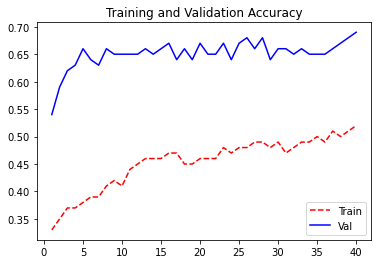

In [32]:
# GRAPH1

plt.plot(epochs3, training3, color = 'red', linestyle='dashed', label = "Train")
#plt.plot(epochs3, training4, color = 'blue', linestyle='dashed', label ="Train: no reg")
#plt.plot(epochs4, validation3, color = 'red', label = "Val: l2 reg")
plt.plot(epochs3, validation3, color = 'blue', label = "Val")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

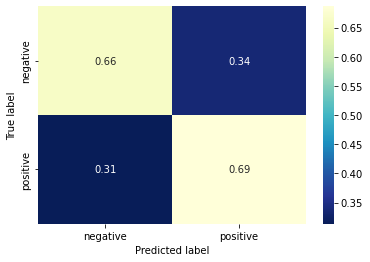

In [34]:
# CONFUSION MATRIX

import seaborn as sns
#plot the confusion matrix
conf = [[0.6637744,  0.3362256],
 [0.31376147, 0.68623853]]
ticks = ['negative', 'positive']
ax = sns.heatmap(conf, annot=True, xticklabels=ticks, yticklabels=ticks, cmap='YlGnBu_r')
ax.set(xlabel='Predicted label', ylabel='True label')
plt.show()

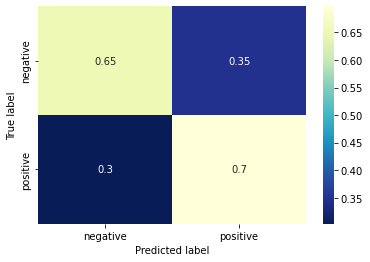

In [35]:
import seaborn as sns
#plot the confusion matrix
conf = [[0.65292842, 0.34707158],
 [0.30275229, 0.69724771]]
ticks = ['negative', 'positive']
ax = sns.heatmap(conf, annot=True, xticklabels=ticks, yticklabels=ticks, cmap='YlGnBu_r')
ax.set(xlabel='Predicted label', ylabel='True label')
plt.show()

In [55]:
 #Prediction:

df = pd.read_csv('tweets_lastw_clean.csv', header=0)
reviews = df['text']    
sentiment = df['pred']

tokenizer = BertTokenizer.from_pretrained("/home/jupyter/pytorch/",
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=40,
                   truncation=True,pad_to_max_length=True)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

X_train, X_val, y_train, y_val = train_test_split(reviews, 
sentiment, stratify=sentiment, test_size=10000, random_state=42)

# Apply preprocessing to dataset
X_val_inputs, X_val_masks = preprocessing(X_val)

y_val_labels = torch.tensor(y_val.values)

batch_size = 32

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler,
                 batch_size=batch_size,
                 num_workers=0)
    return dataloader


val_dataloader = dataloader(X_val_inputs, X_val_masks, 
                 y_val_labels)


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [57]:
run_on = 'cpu'
device = torch.device(run_on)


In [ ]:
# SAVING YOUR MODEL

#from pathlib import Path  
#filepath = Path('Models/model2')  
#torch.save(model.state_dict(), filepath)

In [63]:
# Let's further analyze the positive ones and the negatives
from transformers import BertModel
import torch
from pathlib import Path 

# Change the name of your model
filepath = Path('Models/model1') 
# Import the BERT (BETO) structure
model = BertForSequenceClassification.from_pretrained(
        "/home/jupyter/pytorch/", num_labels=2, output_attentions=False,
         output_hidden_states=False)
# Load your trained weights
model.load_state_dict(torch.load(filepath))
# Start evaluation mode
model.eval()


# Generate the predictions: 

        # Tracking variables
eval_loss, eval_accuracy = 0, 0
all_logits = []
all_labels = []
        # Evaluate data for one epoch
for step, batch in enumerate(val_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
        b_input_ids, b_input_mask, b_labels = tuple(
                    t.to(device) for t in batch)


            # Model will not to compute gradients
        with torch.no_grad():
                # Forward pass 
                # This will return the logits 
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

            # The "logits" are the output values 
            # prior to applying an activation function 
        logits = outputs[0]

            # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        b_labels = b_labels.to('cpu').numpy()

            # Save batch logits and labels 
            # We will use thoses in the confusion matrix
        predict_labels = np.argmax(
                         logits, axis=1).flatten()
        all_logits.extend(predict_labels.tolist())
        all_labels.extend(b_labels.tolist())

Some weights of the model checkpoint at /home/jupyter/pytorch/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

In [64]:
# all_logits is the vector of prediction

x_val = X_val.tolist()
pred_frame = pd.DataFrame (list(zip(x_val,all_logits)), 
                           columns = ['text_val', 'pred_label'])

In [61]:
x_val = X_val.tolist()
pred_frame_2 = pd.DataFrame (list(zip(x_val,all_logits)), 
                           columns = ['text_val', 'pred_label'])

In [65]:
pred_frame.to_csv('Prediction_Model1.csv')

In [62]:
pred_frame_2.to_csv('Prediction_Model2.csv')